### Dataset generation

X shape: (1000, 2)
y shape: (1000,)


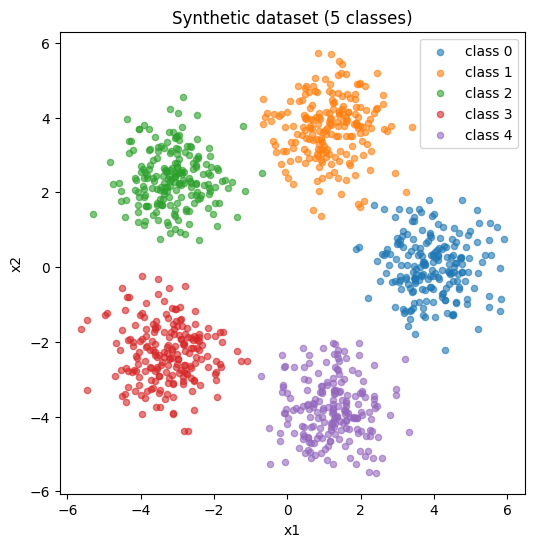

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(0)

# Dataset parameters 
num_classes = 5         
points_per_class = 200  
D = 2                   


X_list = []
y_list = []

# Five clusters are generated 
for class_idx in range(num_classes):
    angle = 2 * np.pi * class_idx / num_classes
    # cluster center is set around a circle
    cx = 4.0 * np.cos(angle)
    cy = 4.0 * np.sin(angle)
    # points are generated from a normal distribution around the center
    Xc = np.random.randn(points_per_class, D) * 0.8 + np.array([cx, cy])
    yc = np.full(points_per_class, class_idx)
    X_list.append(Xc)
    y_list.append(yc)

# Data is combined into single arrays
X = np.vstack(X_list) 
y = np.hstack(y_list)  


print("X shape:", X.shape)
print("y shape:", y.shape)


plt.figure(figsize=(6,6))
for cls in range(num_classes):
    pts = X[y == cls]
    plt.scatter(pts[:,0], pts[:,1], label=f"class {cls}", alpha=0.6, s=20)
plt.legend()
plt.title("Synthetic dataset (5 classes)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


### Train-test split and one-hot helper

In [ ]:


# Data is shuffled before splitting so train and test are random
N = X.shape[0]
perm = np.random.permutation(N)
X = X[perm]
y = y[perm]

# Train-test split 
train_ratio = 0.8
n_train = int(N * train_ratio)
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# One-hot encoding helper is defined because softmax + cross-entropy needs one-hot labels.
def one_hot(labels, num_classes):
    
    n = labels.shape[0]
    oh = np.zeros((n, num_classes))
    for i in range(n):
        oh[i, int(labels[i])] = 1.0
    return oh

# One-hot labels are made for train and test sets.
y_train_oh = one_hot(y_train, num_classes)
y_test_oh = one_hot(y_test, num_classes)


print("y_train_oh shape:", y_train_oh.shape)
print("First 5 one-hot rows:\n", y_train_oh[:5])


Train samples: 800
Test samples: 200
y_train_oh shape: (800, 5)
First 5 one-hot rows:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


### NeuralNetwork class (3 hidden layers)

In [19]:


class NeuralNetwork(object):
    def __init__(self, input_size, h1, h2, h3, out_size, lr=0.1):
        
        self.input_size = input_size
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.out_size = out_size
        
        # Learning rate is set for gradient descent.
        self.learning_rate = lr
        
        
        
        self.W_HI   = np.random.randn(self.input_size, self.h1) * 0.1  
        self.W_H12  = np.random.randn(self.h1, self.h2) * 0.1          
        self.W_H23  = np.random.randn(self.h2, self.h3) * 0.1          
        self.W_OH   = np.random.randn(self.h3, self.out_size) * 0.1    
        
        
        
    
    # Sigmoid activation 
    def sigmoid(self, x, der=False):
        if der:
            
            return x * (1 - x)
        return 1.0 / (1.0 + np.exp(-x))
    
    # Softmax activation is used for the output layer to get probabilities
    def softmax(self, x):
        # Numerically stable softmax is used by subtracting max per row.
        x_shift = x - np.max(x, axis=1, keepdims=True)
        ex = np.exp(x_shift)
        return ex / np.sum(ex, axis=1, keepdims=True)
    
    # Forward pass 
    def feedForward(self, X):
        # Hidden layer 1 computations
        self.hidden_input1 = np.dot(X, self.W_HI)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)
        
        # Hidden layer 2 computations 
        self.hidden_input2 = np.dot(self.hidden_output1, self.W_H12)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)
        
        # Hidden layer 3 computations 
        self.hidden_input3 = np.dot(self.hidden_output2, self.W_H23)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)
        
        # Output layer computation  and softmax 
        output_input = np.dot(self.hidden_output3, self.W_OH)
        pred = self.softmax(output_input)
        return pred
    
    # Cross-entropy loss for multi-class classification
    def compute_loss(self, y_true_oh, y_pred):
        eps = 1e-12  # small epsilon is used to avoid log(0)
        clipped = np.clip(y_pred, eps, 1.0 - eps)
        
        loss = -np.mean(np.sum(y_true_oh * np.log(clipped), axis=1))
        return loss
    
    # Backpropagation is implemented and weights are updated with gradient descent.
    def backPropagation(self, X, y_true_oh, y_pred):
        n = X.shape[0]  
        
        # Gradient at output is (y_pred - y_true)/n for softmax + cross-entropy
        delta_out = (y_pred - y_true_oh) / n  # shape (n, out_size)
        
        # Gradient for W_OH
        dW_OH = np.dot(self.hidden_output3.T, delta_out)  # (h3, out_size)
        
        # Backpropagate to hidden3 layer and compute its delta:
        error_h3 = np.dot(delta_out, self.W_OH.T)  # (n, h3)
        delta_h3 = error_h3 * self.sigmoid(self.hidden_output3, der=True)
        dW_H23 = np.dot(self.hidden_output2.T, delta_h3)  # (h2, h3)
        
        # Backpropagate to hidden2 layer and compute its delta:
        error_h2 = np.dot(delta_h3, self.W_H23.T)  # (n, h2)
        delta_h2 = error_h2 * self.sigmoid(self.hidden_output2, der=True)
        dW_H12 = np.dot(self.hidden_output1.T, delta_h2)  # (h1, h2)
        
        # Backpropagate to hidden1 layer and compute its delta:
        error_h1 = np.dot(delta_h2, self.W_H12.T)  # (n, h1)
        delta_h1 = error_h1 * self.sigmoid(self.hidden_output1, der=True)
        dW_HI = np.dot(X.T, delta_h1)  # (input_size, h1)
        
        # Weights are updated by subtracting learning_rate * gradient.
        self.W_OH  -= self.learning_rate * dW_OH
        self.W_H23 -= self.learning_rate * dW_H23
        self.W_H12 -= self.learning_rate * dW_H12
        self.W_HI  -= self.learning_rate * dW_HI
        
    # Train function 
    def train(self, X, y_true_oh):
        # Forward pass is run
        pred = self.feedForward(X)
        # Backpropagation is run with current batch
        self.backPropagation(X, y_true_oh, pred)
        # Loss is computed so training progress can be reported
        loss = self.compute_loss(y_true_oh, pred)
        return loss


input_size = D
hidden1 = 16
hidden2 = 12
hidden3 = 10
output_size = num_classes
learning_rate = 0.25

NN = NeuralNetwork(input_size, hidden1, hidden2, hidden3, output_size, lr=learning_rate)
print("Network created: {} -> {} -> {} -> {} -> {}".format(input_size, hidden1, hidden2, hidden3, output_size))


Network created: 2 -> 16 -> 12 -> 10 -> 5


### Training loop and loss plot

Epoch 1/500 - loss: 1.6160
Epoch 50/500 - loss: 1.6076
Epoch 100/500 - loss: 0.7912
Epoch 150/500 - loss: 0.0942
Epoch 200/500 - loss: 0.0331
Epoch 250/500 - loss: 0.0217
Epoch 300/500 - loss: 0.0156
Epoch 350/500 - loss: 0.0125
Epoch 400/500 - loss: 0.0106
Epoch 450/500 - loss: 0.0096
Epoch 500/500 - loss: 0.0083


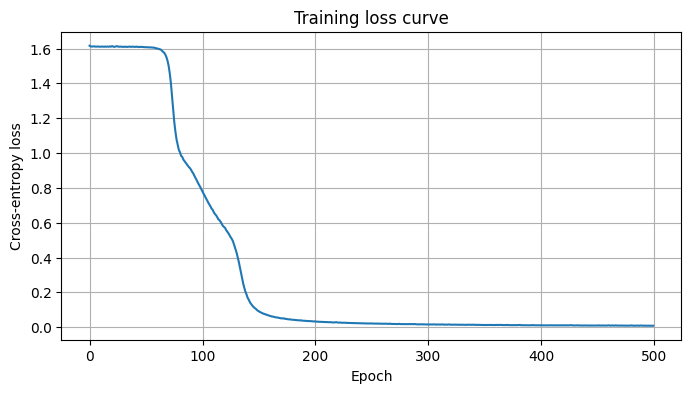

In [20]:


# Training hyperparameters
num_epochs = 500
batch_size = 64

loss_history = []


for epoch in range(num_epochs):
    # Training data is shuffled for each epoch
    perm = np.random.permutation(X_train.shape[0])
    X_sh = X_train[perm]
    y_sh = y_train_oh[perm]
    
    epoch_losses = []
    
    for i in range(0, X_sh.shape[0], batch_size):
        xb = X_sh[i:i+batch_size]
        yb = y_sh[i:i+batch_size]
        loss = NN.train(xb, yb)
        epoch_losses.append(loss)
    
    # Average loss for the epoch is stored
    avg_loss = np.mean(epoch_losses)
    loss_history.append(avg_loss)
    
    
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}")

# Loss curve is plotted
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Training loss curve")
plt.grid(True)
plt.show()


### Evaluation on test set and metrics calculation

Test accuracy: 1.0
Confusion matrix (rows = true class, cols = predicted class):
[[32  0  0  0  0]
 [ 0 37  0  0  0]
 [ 0  0 50  0  0]
 [ 0  0  0 49  0]
 [ 0  0  0  0 32]]

Per-class metrics:
Class 0 Precision: 1.0 Recall: 1.0 F1: 1.0
Class 1 Precision: 1.0 Recall: 1.0 F1: 1.0
Class 2 Precision: 1.0 Recall: 1.0 F1: 1.0
Class 3 Precision: 1.0 Recall: 1.0 F1: 1.0
Class 4 Precision: 1.0 Recall: 1.0 F1: 1.0

Macro Precision: 1.0
Macro Recall: 1.0
Macro F1: 1.0


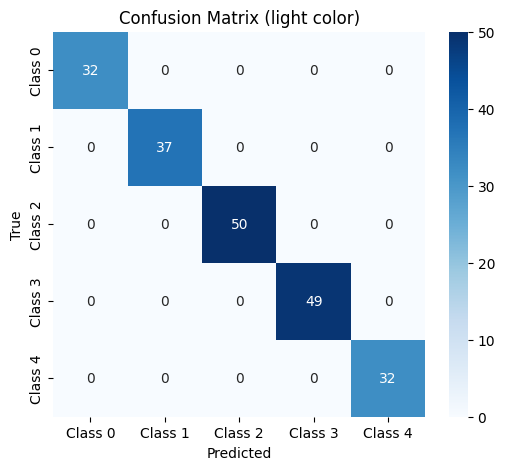

In [21]:



# Forward pass is done on test data to get class scores
y_pred_proba = NN.feedForward(X_test)

# Class is chosen by taking the index with the highest score
y_pred = np.argmax(y_pred_proba, axis=1)

# Accuracy is computed as part_correct / total.
accuracy = np.mean(y_pred == y_test)
print("Test accuracy:", accuracy)

# Confusion matrix (Rows = true class, Cols = predicted class)
conf_mat = np.zeros((num_classes, num_classes), dtype=int)

for true_c, pred_c in zip(y_test.astype(int), y_pred.astype(int)):
    conf_mat[true_c, pred_c] += 1

print("Confusion matrix (rows = true class, cols = predicted class):")
print(conf_mat)

# Precision, recall and f1 are computed for each class by using the confusion matrix
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1 = np.zeros(num_classes)

for cls in range(num_classes):
    TP = conf_mat[cls, cls]
    FP = np.sum(conf_mat[:, cls]) - TP
    FN = np.sum(conf_mat[cls, :]) - TP

   
    if (TP + FP) == 0:
        precision[cls] = 0.0
    else:
        precision[cls] = TP / (TP + FP)

    
    if (TP + FN) == 0:
        recall[cls] = 0.0
    else:
        recall[cls] = TP / (TP + FN)

    
    if (precision[cls] + recall[cls]) == 0:
        f1[cls] = 0.0
    else:
        f1[cls] = 2 * precision[cls] * recall[cls] / (precision[cls] + recall[cls])

print("\nPer-class metrics:")
for cls in range(num_classes):
    print("Class", cls, 
          "Precision:", round(precision[cls], 3),
          "Recall:", round(recall[cls], 3),
          "F1:", round(f1[cls], 3))

# Macro average is done by taking mean of all classes.
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print("\nMacro Precision:", round(macro_precision, 3))
print("Macro Recall:", round(macro_recall, 3))
print("Macro F1:", round(macro_f1, 3))


plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',   
    xticklabels=[f"Class {i}" for i in range(num_classes)],
    yticklabels=[f"Class {i}" for i in range(num_classes)]
)
plt.title("Confusion Matrix (light color)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Sample predictions and decision region visualization

Some sample test predictions (first 10):
Index 0: True 1, Pred 1, Probs [0.    0.998 0.002 0.    0.   ]
Index 1: True 2, Pred 2, Probs [0.    0.    0.981 0.018 0.   ]
Index 2: True 1, Pred 1, Probs [0.001 0.998 0.001 0.    0.   ]
Index 3: True 2, Pred 2, Probs [0.    0.002 0.998 0.    0.   ]
Index 4: True 3, Pred 3, Probs [0.    0.    0.001 0.998 0.001]
Index 5: True 1, Pred 1, Probs [0.    0.998 0.001 0.    0.   ]
Index 6: True 3, Pred 3, Probs [0.    0.    0.001 0.998 0.001]
Index 7: True 3, Pred 3, Probs [0.    0.    0.001 0.998 0.001]
Index 8: True 1, Pred 1, Probs [0.001 0.984 0.015 0.    0.   ]
Index 9: True 3, Pred 3, Probs [0.    0.    0.    0.992 0.008]


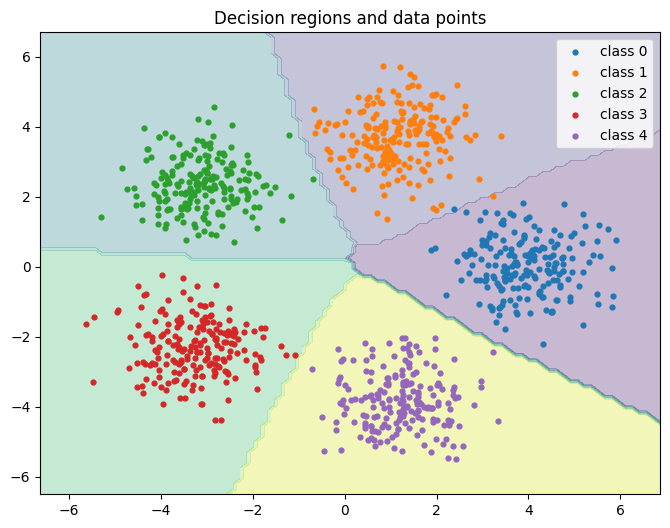

In [22]:



print("Some sample test predictions (first 10):")
for i in range(min(10, X_test.shape[0])):
    true = int(y_test[i])
    predc = int(y_pred[i])
    probs = np.round(y_pred_proba[i], 3)
    print(f"Index {i}: True {true}, Pred {predc}, Probs {probs}")

# Decision region is plotted for the 2D input space to visualize boundaries
h = 0.15  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predictions are run on the grid
Z_proba = NN.feedForward(grid)
Z = np.argmax(Z_proba, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
for cls in range(num_classes):
    pts = X[y == cls]
    plt.scatter(pts[:,0], pts[:,1], label=f"class {cls}", s=12)
plt.legend()
plt.title("Decision regions and data points")
plt.show()
